### Введение. Постановка задач.

2017 год. Частный инвестор ищет команду аналитиков, способных разгадать ход игры

Задачи в рамках Python:

1.	С помощью статистических методов определить 2-3 ключевые характеристики, которые критически влияют на исход матча.

2.	Подготовить базы данных для присоединения к дашборду.

In [56]:
# Импорт необходимых библиотек
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import seaborn as sns

In [57]:
# Загрузка датасетов с информацией о матчах, командах и игроках
Match = pd.read_csv('Match.csv')
Team = pd.read_csv('Team.csv')
Player = pd.read_csv('Player.csv')

### 1. Таблица Match. Первая ключевая характеристика - результативность.

In [58]:
#Проверка загруженных данных
Match.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25979 entries, 0 to 25978
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   match_api_id          25979 non-null  int64 
 1   country_league_id     25979 non-null  int64 
 2   country_name          25979 non-null  object
 3   league_name           25979 non-null  object
 4   season                25979 non-null  object
 5   home_team_api_id      25979 non-null  int64 
 6   home_team_long_name   25979 non-null  object
 7   home_team_short_name  25979 non-null  object
 8   away_team_api_id      25979 non-null  int64 
 9   away_team_long_name   25979 non-null  object
 10  away_team_short_name  25979 non-null  object
 11  home_team_goal        25979 non-null  int64 
 12  away_team_goal        25979 non-null  int64 
dtypes: int64(6), object(7)
memory usage: 2.6+ MB


##### Вывод: 
Таблица содержит информацию о 25 979 матчах и состоит из 13 столбцов. Пропуски в данных отсутствуют.

In [59]:
#Проверка на дубли
Match[Match.duplicated()]

,match_api_id,country_league_id,country_name,league_name,season,home_team_api_id,home_team_long_name,home_team_short_name,away_team_api_id,away_team_long_name,away_team_short_name,home_team_goal,away_team_goal


##### Вывод: 
Дублирование данных отсутствует.

In [60]:
#Добавление счетчика количества матчей и информации о заработанных баллах  
Match['Points_home'] = Match.apply(lambda row: 3 if row['home_team_goal']>row['away_team_goal'] else 
                                (1 if row['home_team_goal'] == row['away_team_goal'] else 0), axis=1)
Match['Points_away'] = Match.apply(lambda row: 3 if row['away_team_goal']>row['home_team_goal'] else 
                                (1 if row['away_team_goal'] == row['home_team_goal'] else 0) , axis=1)
Match['Count_match'] = 1

# Разделение таблицы на домашние и гостевые матчи
df_home = Match[['season', 'home_team_api_id', 'home_team_long_name','home_team_short_name', 'country_league_id',"league_name", 'Points_home', 'Count_match']]
df_home.rename(columns= {'home_team_api_id':'team_api_id', 
                         'home_team_long_name':'team_long_name', 
                         'home_team_short_name':'team_short_name',
                         'Points_home':'Points'}, inplace=True) #переименование столбцов


df_away = Match[['season',  'away_team_api_id', 'away_team_long_name','away_team_short_name', 'country_league_id', "league_name", 'Points_away', 'Count_match']]
df_away.rename(columns= {'away_team_api_id':'team_api_id', 
                         'away_team_long_name':'team_long_name', 
                         'away_team_short_name':'team_short_name',
                         'Points_away':'Points'}, inplace=True)#переименование столбцов

#Группировка матчей по сезонам и командам, добавление столбца Place - место проведения игры
def group_table(d):
    df = d.groupby(['season','team_api_id', 'team_long_name','team_short_name', 'country_league_id', "league_name"]).sum()
    df.reset_index(inplace= True)
    df.sort_values(by= 'team_api_id', inplace=True)
    return df

home = group_table(df_home)
home['Place'] = 'home'

away = group_table(df_away)
away['Place'] = 'away'

#Объединение таблиц
df_match = pd.concat([home, away])

#Загружаем информацию о рейтинг лиг в разные сезоны и добавляем к таблице 
league_rating = pd.read_csv('Country.csv')
df_match = pd.merge(df_match, league_rating, on = ['country_league_id', 'season'], how = 'left') 

#Расчет среднего балла за сезон, скорректированного на рейтинг лиги
df_match['avg_score'] = df_match.apply(lambda row: (row['Points']/row['Count_match'])*row['league_rating'], axis=1)

#Cохраняем только нужные для дашборда столбцы
data_1 = df_match[['season', 'team_api_id', 'team_long_name', 'team_short_name', 'Points', 'Count_match', 'avg_score', 'Place', 
                   "league_name", 'league_rating']]

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\frame.py:4296: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


### 2. Таблица Team. Вторая ключевая характеристика - общий балл команды.

#### 2.1 Предобработка данных

In [61]:
#Проверка загруженных данных
Team.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1457 entries, 0 to 1456
Data columns (total 28 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   team_api_id                     1457 non-null   int64  
 1   team_long_name                  1457 non-null   object 
 2   team_short_name                 1457 non-null   object 
 3   country_name                    1457 non-null   object 
 4   league_name                     1457 non-null   object 
 5   date                            1457 non-null   object 
 6   buildUpPlaySpeed                1457 non-null   int64  
 7   buildUpPlaySpeedClass           1457 non-null   object 
 8   buildUpPlayDribbling            488 non-null    float64
 9   buildUpPlayDribblingClass       1457 non-null   object 
 10  buildUpPlayPassing              1457 non-null   int64  
 11  buildUpPlayPassingClass         1457 non-null   object 
 12  buildUpPlayPositioningClass     14

##### Вывод: 
Таблица состоит из 1457 строк и 28 столбцов. 
В столбцe "buildUpPlayDribbling" присутсвуют пропуски, необходимо проведение предобработки данных.

In [62]:
#Проверка на дубли
Team[Team.duplicated()]

,team_api_id,team_long_name,team_short_name,country_name,league_name,date,buildUpPlaySpeed,buildUpPlaySpeedClass,buildUpPlayDribbling,buildUpPlayDribblingClass,...,chanceCreationShootingClass,chanceCreationPositioningClass,defencePressure,defencePressureClass,defenceAggression,defenceAggressionClass,defenceTeamWidth,defenceTeamWidthClass,defenceDefenderLineClass,season


##### Вывод: 
Дублирование данных отсутствует.

In [63]:
#Анализ пропусков
Team[Team["buildUpPlayDribbling"].isna()]["buildUpPlayDribblingClass"].value_counts()

#Замена пропусков
Team["buildUpPlayDribbling"].fillna(Team[Team["buildUpPlayDribblingClass"] == "Little"]["buildUpPlayDribbling"].mean(), 
                                    inplace=True)

##### Вывод: 
В ходе анализа выявлено 969 пропусков по столбцу "buildUpPlayDribbling", по категории little из столбца "buildUpPlayDribblingClass".
В связи с этим пропуски заменены средним значением категории little.


#### 2.2 Подготовка базы данных для присоединения к дашборду.

In [64]:
#Удаление столбцов, не участвующих в анализе
Team.drop(columns= ["buildUpPlaySpeedClass", "buildUpPlayDribblingClass", "buildUpPlayPassingClass", "buildUpPlayPositioningClass", 
                    "chanceCreationCrossingClass", "chanceCreationShootingClass", "chanceCreationPositioningClass", "chanceCreationPassing", "chanceCreationPassingClass", 
                     "defencePressureClass", "defenceAggressionClass", "defenceDefenderLineClass", "defenceTeamWidth", "defenceTeamWidthClass"], inplace= True)

#Подсчет рейтинга команды по показателям:
''' 1. Показатели тактики команды в атаке - скорость атаки команды, уровень дриблинга команды в нападении, уровень передач в атаке
2. Показатели тактики команды при создании голевых моментов - количество навесов в штрафной зоне, количество ударов по воротам
3. Показатели тактики команды в обороне - прессинг в обороне, агрессивность в обороне '''

Team["Team_rating"] = Team.apply(lambda row:((row['buildUpPlaySpeed']+row['buildUpPlayPassing'] + row["buildUpPlayDribbling"])/3)*0.34
                                 + ((row['chanceCreationCrossing'] + row['chanceCreationShooting'])/2)*0.33
                                + ((row['defencePressure'] + row['defenceAggression'])/2) *0.33,
                                 axis=1)

#Нахождение среднего рейтинга команд в разрезе сезонов 
df_team = Team.groupby(['season','team_api_id', 'team_long_name','team_short_name']).mean()
df_team.reset_index(inplace= True)
df_team.sort_values(by= ['team_api_id', 'season'], inplace=True)


#Cохраняем только нужные для дашборда столбцы
data_2 = df_team[['season', 'team_api_id', 'Team_rating']]

### 3. Таблица Player. Третья ключевая характеристика - средний балл игроков команды.

#### 3.1 Предобработка данных

In [65]:
#Проверка загруженных данных
Player.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 188304 entries, 0 to 188303
Data columns (total 12 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   player_api_id    188304 non-null  int64  
 1   player_name      188304 non-null  object 
 2   birthday         188304 non-null  object 
 3   overall_rating   188304 non-null  int64  
 4   potential        188304 non-null  int64  
 5   Date             188304 non-null  object 
 6   season           188304 non-null  object 
 7   team_api_id      118688 non-null  float64
 8   team_long_name   118688 non-null  object 
 9   team_short_name  118688 non-null  object 
 10  country_name     118688 non-null  object 
 11  league_name      118688 non-null  object 
dtypes: float64(1), int64(3), object(8)
memory usage: 17.2+ MB


##### Вывод: 
Таблица состоит из 188 304 строк и 11 столбцов. 
В ряде столбцов присутсвуют пропуски, необходимо проведение предобработки данных.

In [66]:
#Проверка на дубли
Player[Player.duplicated()]

,player_api_id,player_name,birthday,overall_rating,potential,Date,season,team_api_id,team_long_name,team_short_name,country_name,league_name


##### Вывод: 
Дублирование данных отсутствует.

In [67]:
Player.dropna(subset=['league_name'], inplace=True)

##### Вывод: 
В ходе анализа выявлено 69 616 пропусков по столбцам содержащим информацию о команде, к которой относится игрок.
В связи с этим строки с пропусками удалены.

#### 3.2 Подготовка базы данных для присоединения к дашборду.

In [68]:
#Нахождение среднего рейтинга игроков команд в разрезе сезонов
df_player = pd.pivot_table(Player, index = ['season', "team_api_id", 'team_short_name'], values = ('overall_rating', 'potential'), aggfunc = 'mean')
df_player.reset_index(inplace=True)
df_player.sort_values(by= ['team_api_id', 'season'], inplace=True)

#Cохраняем только нужные для дашборда столбцы
data_3 = df_player[['season', 'team_api_id', 'overall_rating', 'potential']]

In [69]:
# Объединение трех таблиц для дашборда в одну
data_all = pd.merge(data_1, data_2, on = ['team_api_id', 'season'], how = 'left')
data_all = pd.merge(data_all, data_3, on = ['team_api_id', 'season'], how = 'left')

#Проверка и замена пропусков
data_all.isnull().sum()
data_all['Team_rating'].fillna(0, inplace = True)

In [70]:
#Нормализация ключевых характеристик
def min_max(d):
    x = d.values.reshape(-1,1)
    min_max_scaler = MinMaxScaler()
    min_max_scaler.fit(x)
    x_min_max_scaled = min_max_scaler.transform(x)
    return x_min_max_scaled

data_all['coef_1'] = min_max(data_all['avg_score'])
data_all['coef_2'] = min_max(data_all['Team_rating'])
data_all['coef_3'] = min_max(data_all['overall_rating'])

In [51]:
#Сохранение csv файла
data_all.to_csv('Data.csv', index = False)

### 4. Анализ данных.

Text(0, 0.5, 'Количество матчей')

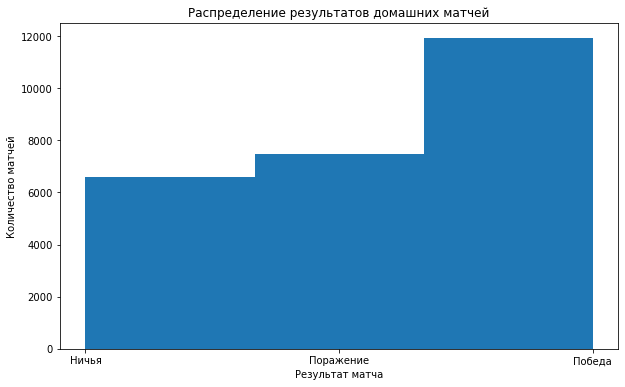

In [71]:
#Построение графика распределения результатов домашних матчей
Points = Match.Points_home
to_replace = {1: "Ничья", 3: "Победа", 0: "Поражение"}
Points = Points.replace(to_replace)

plt.figure(figsize= (10,6))
plt.hist(Points, bins=3)
plt.title('Распределение результатов домашних матчей')
plt.xlabel("Результат матча")
plt.ylabel("Количество матчей")

##### Вывод: 
Распределение результатов домашних матчей является обратным распределением результатов гостевых матчей, поскольку победа в домашнем матче означает поражение в гостевом. 

Согласно графику распределения, количество побед в домашних матчах, превышает количество побед в гостевых в 1,5 раза. Исходя из этого можно сделать вывод, что место проведения матча для команды является существенным признаком, влияющим на результат.

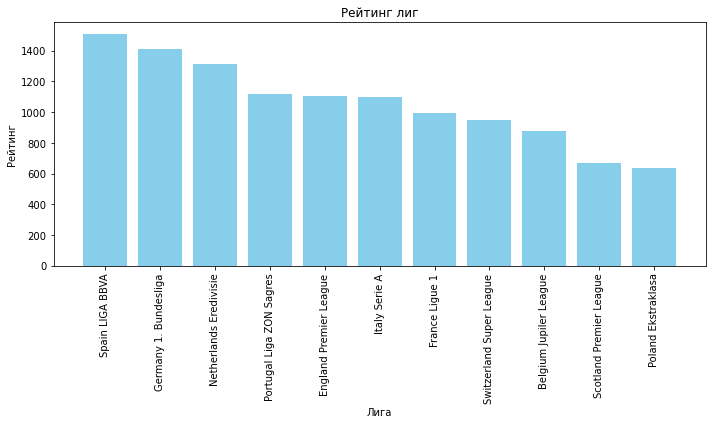

In [72]:
#Построение графика Рейтинг лиг
# Создаем график по рейтингу лиг
sorted_data = data_all.groupby('league_name')['league_rating'].agg('mean')
sorted_data = sorted_data.reset_index()
sorted_data = sorted_data.sort_values(by = 'league_rating', ascending = False)
plt.figure(figsize=(10, 6))
plt.bar(sorted_data['league_name'], sorted_data['league_rating'], color='skyblue')
plt.title('Рейтинг лиг')
plt.xlabel('Лига')
plt.ylabel('Рейтинг')
plt.xticks(rotation=90)

# Отображаем график
plt.tight_layout()
plt.show()

##### Вывод: 
Испанская футбольная лига является самой сильной, самая слабая футбольная лига - польская

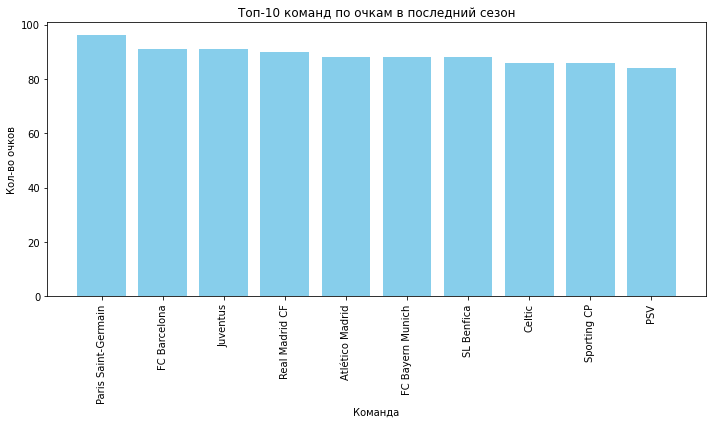

In [73]:
#Построение графика Топ-10 команд по очкам в последний сезон
# Сортируем данные по столбцу 'Team_rating' в убывающем порядке
sorted_data = data_all[data_all['season'] == '2015/2016']
sorted_data = sorted_data.groupby('team_long_name')['Points'].agg('sum')
sorted_data = sorted_data.reset_index()
sorted_data.sort_values(by='Points', ascending=False, inplace=True)

# Выбираем только первые 10 команд в последний сезон
top_10_data = sorted_data.head(10)

# Создаем график
plt.figure(figsize=(10, 6))
plt.bar(top_10_data['team_long_name'], top_10_data['Points'], color='skyblue')
plt.title('Топ-10 команд по очкам в последний сезон')
plt.xlabel('Команда')
plt.ylabel('Кол-во очков')
plt.xticks(rotation=90)

# Отображаем график
plt.tight_layout()
plt.show()

##### Вывод: 
Наибольшее количество очков в последнем сезоне заработала команда PSG

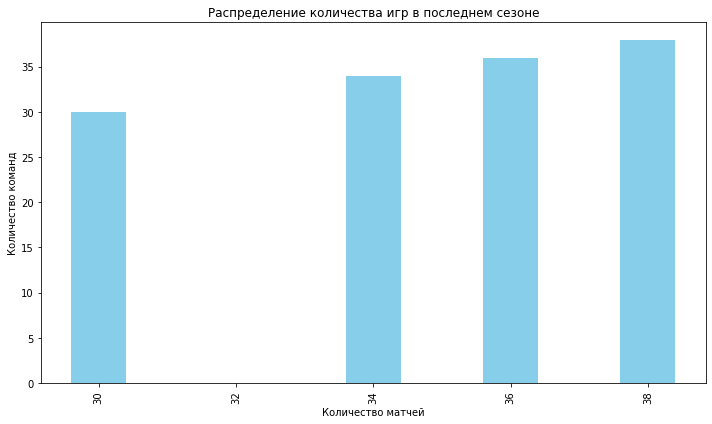

In [74]:
#Построение графика количества игр в последнем сезоне
# Сортируем данные по столбцу 'Team_rating' в убывающем порядке
sorted_data = data_all[data_all['season'] == '2015/2016']
sorted_data = sorted_data.groupby('team_long_name')['Count_match'].agg('sum')
sorted_data = sorted_data.reset_index()
sorted_data.sort_values(by='Count_match', ascending=False, inplace=True)


# Создаем график
plt.figure(figsize=(10, 6))
plt.bar(sorted_data['Count_match'], sorted_data['Count_match'], color='skyblue')
plt.title('Распределение количества игр в последнем сезоне')
plt.xlabel('Количество матчей')
plt.ylabel('Количество команд')
plt.xticks(rotation=90)

# Отображаем график
plt.tight_layout()
plt.show()

##### Вывод: 
Большинство команд в последнем сезоне сыграло 38, 36, 34 и 30 матчей. Наименьшая доля команд сыграла 32 матча.

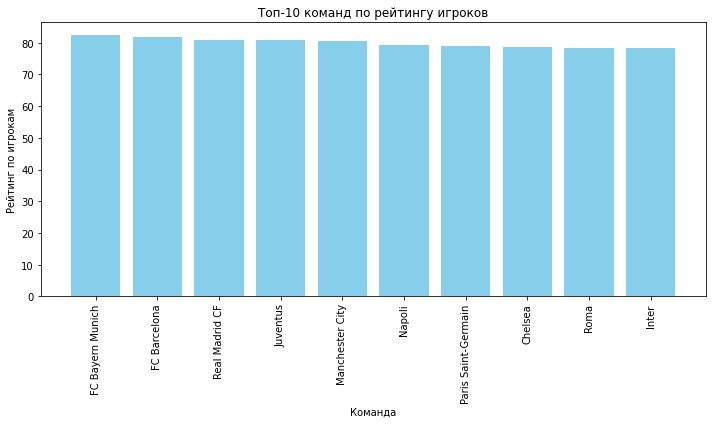

In [75]:
#Построение графика Топ-10 команд по рейтингу игроков
# Сортируем данные по столбцу 'overall_rating' в убывающем порядке
sorted_data = data_all[data_all['season'] == '2015/2016']
sorted_data = sorted_data.groupby('team_long_name')['overall_rating'].agg('mean')
sorted_data = sorted_data.reset_index()
sorted_data.sort_values(by='overall_rating', ascending=False, inplace=True)

# Выбираем только первые 10 команд в последний сезон
top_10_data = sorted_data.head(10)

# Создаем график
plt.figure(figsize=(10, 6))
plt.bar(top_10_data['team_long_name'], top_10_data['overall_rating'], color='skyblue')
plt.title('Топ-10 команд по рейтингу игроков')
plt.xlabel('Команда')
plt.ylabel('Рейтинг по игрокам')
plt.xticks(rotation=90)

# Отображаем график
plt.tight_layout()
plt.show()

##### Вывод: 
В командах FC Bayern Munich и FC Barcelona наивысший средний балл игроков. 

<AxesSubplot:>

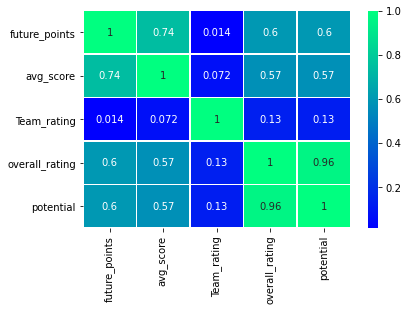

In [76]:
#Построение корреляционной матрицы

#Корректируем баллы за сезон на рейтинг лиги
data_all['Points_total'] = data_all.apply(lambda row:row['Points']*row['league_rating'],
                                 axis=1)

# Сортируйте DataFrame по team_api_id и season
data_all = data_all.sort_values(by=['team_api_id', 'Place', 'season'])

# Используем метод shift для создания нового столбца со значениями Points_total из следущего сезона
data_all['future_points'] = data_all.groupby(['team_api_id', 'Place'])['Points_total'].shift(-1)

#Строим корреляцию
sns.heatmap(data_all[['future_points', 'avg_score', 'Team_rating', 'overall_rating', 'potential']].corr(), 
            annot=True, cmap='winter', linewidths=0.5)

##### Вывод: 
В рамках корреляционного анализа были сопоставлены рассчитанные метрики команд текущего сезона со значениями полученных командами очков в следующем сезоне для установления взаимосвязи и проверки метрик на значимость. 

Результативный признак (future_points) в наибольшей степни коррелирует с фактором среднее количество очков за матч, скорректированное на рейтинг лиги (avg_score), значение коэффицента корреляции = 0,74 - связь высокая. 

Также наблюдается корреляция с факторами: средний балл игроков команды (overall_rating) и средний потенциал игроков команды (potential). Значения коэффицентов коореляции (0.6) свидетельствуют о средней силе связи. 

Вместе с тем, факторы potential и overall_rating сильно коррелируют друг с другом (коэффицент корреляции = 0.96), из чего возникает проблема мультиколлинеарности, которая приводит к увеличению статистической неопределенности и росту дисперсии оценок параметров. В связи с этим фактор potential не включается в модель.

Второй ключевой показатель - средний балл команды (Team_rating) очень слабо коррелирует с результативным признаком - 0.014. Можно сделать вывод о незначимости параметра и нецелесообразности включения его в модель.

Таким образом, для дальнейшего анализа будут использованы следующие факторы: среднее количество очков за матч, скорректированное на рейтинг лиги (avg_score = coef_1) и средний балл игроков команды (overall_rating = coef_3)